In [1]:
%pip install rdkit

     |████████████████████████████████| 34.9 MB 3.9 MB/s eta 0:00:01    |█████████                       | 9.7 MB 3.9 MB/s eta 0:00:07     |███████████                     | 12.0 MB 3.9 MB/s eta 0:00:06
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models

2024-04-29 14:19:24.893666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:19:26.529496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-29 14:19:26.529658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-29 14:19:26.529677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
tf.config.list_physical_devices()

2024-04-29 14:19:28.578425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-29 14:19:28.578475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hires-lambda1.cs.unc.edu
2024-04-29 14:19:28.578487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hires-lambda1.cs.unc.edu
2024-04-29 14:19:28.578645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.12
2024-04-29 14:19:28.578685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.12
2024-04-29 14:19:28.578695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.104.12


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
import time
import pickle
import json

In [6]:
# drugood-sbap-core-ic50-protein

# file_path = '/content/drive/MyDrive/sbap_core_ec50_protein.json'
file_path = './sbap_core_potency_protein.json'
with open(file_path, 'r') as f:
  data = json.load(f)

# Data is a nested JSON structired
print(data.keys())
print()

for key in data.keys():
  print(key, len(data[key]))
  nested_keys = data[key].keys()
  print(f"Nested Keys in {key}: {nested_keys}")
  print()

dict_keys(['cfg', 'split', 'statistics'])

cfg 6
Nested Keys in cfg: dict_keys(['path', 'uncertainty', 'classification_threshold', 'fractions', 'noise_filter', 'domain'])

split 5
Nested Keys in split: dict_keys(['train', 'ood_val', 'ood_test', 'iid_val', 'iid_test'])

statistics 16
Nested Keys in statistics: dict_keys(['thr_for_cls', 'positive_samples', 'negative_samples', 'positive_rate', 'train domain number', 'val domain number', 'test domain number', 'train datapoints', 'ood_val datapoints', 'ood_test datapoints', 'iid_val datapoints', 'iid_test datapoints', 'ood_val domain number', 'ood_test domain number', 'iid_val domain number', 'iid_test domain number'])



In [7]:
# Access split section of data
split_data = data['split']

# Load Data Splits
train_data = split_data['train']
iid_val_data = split_data['iid_val']
iid_test_data = split_data['iid_test']
ood_val_data = split_data['ood_val']
ood_test_data = split_data['ood_test']

# You can now print or inspect the first row of each of these as DataFrames
print("Train Data First Row:")
print(train_data[0])

print("\nOOD Validation Data First Row:")
print(ood_val_data[0])

print("\nOOD Test Data First Row:")
print(ood_test_data[0])

print("\nIID Validation Data First Row:")
print(iid_val_data[0])

print("\nIID Test Data First Row:")
print(iid_test_data[0])

Train Data First Row:
{'smiles': 'CCN1C(=O)c2cccc3cccc1c23', 'reg_label': 4.6, 'assay_id': 688665, 'protein': 'MADKVLKEKRKLFIRSMGEGTINGLLDELLQTRVLNKEEMEKVKRENATVMDKTRALIDSVIPKGAQACQICITYICEEDSYLAGTLGLSADQTSGNYLNMQDSQGVLSSFPAPQAVQDNPAMPTSSGSEGNVKLCSLEEAQRIWKQKSAEIYPIMDKSSRTRLALIICNEEFDSIPRRTGAEVDITGMTMLLQNLGYSVDVKKNLTASDMTTELEAFAHRPEHKTSDSTFLVFMSHGIREGICGKKHSEQVPDILQLNAIFNMLNTKNCPSLKDKPKVIIIQACRGDSPGVVWFKDSVGVSGNLSLPTTEEFEDDAIKKAHIEKDFIAFCSSTPDNVSWRHPTMGSVFIGRLIEHMQEYACSCDVEEIFRKVRFSFEQPDGRAQMPTTERVTLTRCFYLFPGH', 'cls_label': 0, 'domain_id': 41}

OOD Validation Data First Row:
{'smiles': 'OC(c1ccncc1)(c1ccc(F)cc1)c1ccc(F)cc1', 'reg_label': 5.3, 'assay_id': 688400, 'protein': 'MSQLSSTLKRYTESARYTDAHYAKSGYGAYTPSSYGANLAASLLEKEKLGFKPVPTSSFLTRPRTYGPSSLLDYDRGRPLLRPDITGGGKRAESQTRGTERPLGSGLSGGSGFPYGVTNNCLSYLPINAYDQGVTLTQKLDSQSDLARDFSSLRTSDSYRIDPRNLGRSPMLARTRKELCTLQGLYQTASCPEYLVDYLENYGRKGSASQVPSQAPPSRVPEIISPTYRPIGRYTLWETGKGQAPGPSRSSSPGRDGMNSKSAQGLAGLRNLGNTCFMNSILQCLSNTRELRDYCLQRLYMRDLHHGSNAHTALVE

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
import numpy as np

# RDKit for SMILES
def smiles_to_ecfp(smiles, radius=2, nbits=2048):
    mol = Chem.MolFromSmiles(smiles)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
    array = np.zeros((0,), dtype=int)
    DataStructs.ConvertToNumpyArray(ecfp, array)
    return array

# Function to convert your data into a feature matrix
def convert_data_to_features(data):
    smiles_features = []
    #protein_features = []
    for entry in data:
        smiles = entry['smiles']
        #protein = entry['protein']

        smiles_features.append(smiles_to_ecfp(smiles))

        # Truncate or pad protein sequence if necessary
        #protein_sequence = protein[:100]  # example with max length of 100
        #protein_sequence = protein_sequence.ljust(100, 'A')  # padding with alanine (can choose any)
        #protein_features.append(one_hot_protein(protein_sequence))

    smiles_features = np.array(smiles_features)
    #protein_features = np.array(protein_features)

    # Combine and normalize features
    #combined_features = np.hstack((smiles_features, protein_features))
    #combined_features = (combined_features - np.mean(combined_features, axis=0)) / np.std(combined_features, axis=0)

    return smiles_features
    #return combined_features

In [9]:
### ALL IID DATA
train_features = convert_data_to_features(train_data)
#val_features = convert_data_to_features(iid_val_data)
#test_features = convert_data_to_features(iid_test_data)

train_labels = np.array([entry['cls_label'] for entry in train_data])
#val_labels = np.array([entry['cls_label'] for entry in iid_val_data])
#test_labels = np.array([entry['cls_label'] for entry in iid_test_data])

In [10]:
## Very imbalanced
print(train_labels[:10])
print(sum(train_labels))
print(len(train_labels))
print(sum(train_labels)/len(train_labels))

[0 1 0 0 0 1 1 1 0 0]
6880
12699
0.5417749429088905


In [11]:
# Now you can use train_features in place of dataX and train_labels in place of dataY
X = tf.cast(train_features, tf.float32)
Y = tf.cast(train_labels, tf.float32)

pperm = np.random.permutation(len(X))

X = tf.constant(np.array(X)[pperm])
Y = tf.constant(np.array(Y)[pperm])

X = X[:int(len(X)/1.3)]
Y = Y[:len(X)]

2024-04-29 14:19:37.918506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
print(sum(Y)/len(Y))

tf.Tensor(0.5403358, shape=(), dtype=float32)


In [13]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
#sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

In [14]:
print(X.shape)
print(Y.shape)

(9768, 2048)
(9768,)


In [15]:
ood_val_features = convert_data_to_features(ood_val_data)
# ood_test_features = convert_data_to_features(ood_test_data)

ood_val_labels = np.array([entry['cls_label'] for entry in ood_val_data])
# ood_test_labels = np.array([entry['cls_label'] for entry in ood_test_data])

In [16]:
external_X = tf.cast(ood_val_features, tf.float32)
# external_X = tf.cast(ood_test_features, tf.float32)
external_Y = ood_val_labels
# external_Y = ood_test_labels

In [17]:
class RandFeats:
  def __init__(self, sigma_rot, d, D=160):

    self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    # self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X, xD):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(X[rprm[:100], :], X[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X.shape[1], int(X.shape[1]*xD))

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [18]:
Dx = [1.5, 2, 4, 8, 10, 16]

In [19]:
def get_rand_feats(X, model):
  """
  Args:
    X: N x d matrix of input features
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector

  Returns:
    Phis: N x D matrix of random features
  """
  # XWs = tf.matmul(X, Ws)
  # return tf.cos(XWs+bs)
  return model(X)

In [30]:
def linear_coefs(X, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  # start = time.time()
  clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, Y)
  # end = time.time()
  # print(end-start)
  # clf = LogisticRegression(random_state=0).fit(X, Y)
  print(clf.score(X, Y))
  wgts = np.hstack((clf.intercept_[:,None], clf.coef_))
  prd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.T)) > 0.5) *1.0
  # print(np.mean(prd[:, 0]==Y))
  return wgts
  # beta = tf.linalg.solve(tf.matmul(tf.transpose(X),X), tf.matmul(tf.transpose(X), Y[:, None]))
  # return beta

In [31]:
def project_and_filter(X, dir, percentile=75):
  projs = np.dot(X, dir)
  thresh = np.percentile(projs, 100 - percentile)
  filtered_idxs = projs >= thresh
  return X[filtered_idxs], filtered_idxs

In [37]:
def get_models(X, Y, pca_projs, dirs, model, percentile=75):
  #X_subsets = []
  #data_ids = []
  #Y_subsets = []
  betas = []
  i = 0
  for dir in dirs: # TODO: Vectorize
    if i % 25 == 0: print(f"Step {i}")
    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    # print((X_sub@pca_projs).shape)
    est = RandomForestClassifier(n_estimators=40)
    est.fit(get_rand_feats(X_sub@pca_projs, model), Y_sub)
    print(est.score(get_rand_feats(X_sub@pca_projs, model), Y_sub))
    # beta = linear_coefs(get_rand_feats(X_sub@pca_projs, model), Y_sub)

    #X_subsets.append(X_sub)
    #data_ids.append(X_ids)
    #Y_subsets.append(Y_sub)
    betas.append(est)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

  # cant do this because subsets of variable sizes
  #X_subsets = np.array(X_subsets)
  #data_ids = np.array(data_ids)
  #Y_subsets = np.array(Y_subsets)
  # betas = np.array(betas)

  return betas
  #return X_subsets, data_ids, Y_subsets, betas

In [38]:
s, u, v = tf.linalg.svd(X)

In [39]:
dims = [0.05, 0.1, 0.2, 0.5, 0.8]
pca_projs = v[:, :int(X.shape[-1]*dims[1])]

In [40]:
X.shape, pca_projs.shape

(TensorShape([9768, 2048]), TensorShape([2048, 204]))

In [41]:
np.random.seed(74)
X_prjs = np.array(X@pca_projs)
# model = define_rand_feats(X_prjs, Dx[2])
model = define_rand_feats(X_prjs, 1.5)

N = 2**8    # ~ 8k
# N = 2**2    # ~ 8k
d = X.shape[-1]
random_dirs = np.random.randn(N, d) # Maybe do the random directions in the random feature space??? Feel like that makes more sense

random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)

#X_subsets, data_ids, Y_subsets, betas = get_models(X, Y, random_dirs, Ws, bs, percentile=33)
betas = get_models(X, Y, pca_projs, random_dirs, model, percentile=45)

Step 0
0.9556414922656961
0.9572338489535942
0.9535941765241128
0.9638307552320291
0.9538216560509554
0.9531392174704276
0.9558689717925387
0.9590536851683349
0.9608735213830755
0.9522292993630573
0.956343792633015
0.9576888080072793
0.9558890404729422
0.9565612917898567
0.9581437670609645
0.9647406733393995
0.9590536851683349
0.9538216560509554
0.9520127359563338
0.9590629974982943
0.95950864422202
0.9599636032757052
0.9524567788898999
0.9542766151046406
0.9556414922656961
Step 25
0.9590536851683349
0.9581437670609645
0.9622383985441311
0.9588262056414922
0.9636198271941792
0.9572338489535942
0.9526842584167425
0.9608735213830755
0.9581437670609645
0.9554140127388535
0.9599636032757052
0.9549692972481237
0.9592811646951774
0.9522292993630573
0.9535941765241128
0.9601910828025477
0.9642857142857143
0.9570063694267515
0.9570063694267515
0.9613284804367607
0.9558890404729422
0.9515468607825296
0.9572338489535942
0.9606460418562329
0.9599636032757052
Step 50
0.954049135577798
0.9526842584

In [42]:
# np.save('random_dirs-drug1.npy', random_dirs)
# np.save('betas-drug1.npy', betas)
# np.save('Ws-drug1.npy', model.Ws)

# random_dirs = np.load('random_dirs.npy')
# betas = np.load('betas.npy')

In [28]:
random_dirs = tf.constant(np.load('./random_dirs-drug1.npy'))
betas = tf.squeeze(tf.constant(np.load('betas-drug1.npy')))
model = define_rand_feats(X_prjs, 1.5)
model.Ws = tf.constant(np.load('Ws-drug1.npy'))

In [29]:
betas = tf.squeeze(betas)
print(betas.shape)
random_dirs = tf.constant(random_dirs)
print(random_dirs.shape)

(256, 3061)
(256, 2048)


In [30]:
var = tf.math.reduce_variance(betas, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(0.02212257796498803, shape=(), dtype=float64)


In [31]:
sample = 30
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

X_sub, X_ids = project_and_filter(X, random_dirs[sample], 20)
Y_sub = Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

np.mean(prd == Y_sub)

0.5266120777891504

In [32]:
ex_X = tf.cast(external_X, tf.float32)
ex_Y = external_Y
ex_X = (ex_X-mu_x)/sigma_x

X_sub, X_ids = project_and_filter(ex_X, random_dirs[sample], 20)
Y_sub = ex_Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.471841704718417

## Should test Betas performance first

In [39]:
# from tensorflow.keras import layers, models

# beta_dim = betas.shape[-1]
# input_dir_dim = random_dirs.shape[-1]
# latent_dim = 64

# # Encoder
# beta_input = layers.Input(shape=(beta_dim,))
# beta_x = layers.Dense(256, activation=tf.nn.elu)(beta_input)
# dir_input = layers.Input(shape=(input_dir_dim,))
# encoder_inputs = layers.Concatenate()([beta_x, dir_input])
# x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
# x = layers.Dense(256, activation=tf.nn.elu)(x)
# x = layers.Dense(128, activation=tf.nn.elu)(x)
# x = layers.Dense(64, activation=tf.nn.elu)(x)
# # x = layers.Dense(32, activation=tf.nn.elu)(x)
# z_mean = layers.Dense(latent_dim)(x)
# z_log_var = layers.Dense(latent_dim)(x)

# def sampling(args):
#   z_mean, z_log_var = args
#   eps = tf.random.normal(shape=tf.shape(z_mean))
#   return z_mean + tf.exp(0.5 * z_log_var) * eps

# z = layers.Lambda(sampling)([z_mean, z_log_var])


# ### Using direction in Decoder is weird
# ### Likely just train VAE solely on betas with directions


# # Decoder
# latent_inputs = layers.Input(shape=(latent_dim,))
# decoder_dir_input = layers.Input(shape=(input_dir_dim,))
# decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
# # x = layers.Dense(32, activation=tf.nn.elu)(decoder_inputs)
# x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
# # x = layers.Dense(128, activation=tf.nn.elu)(x)
# x = layers.Dense(256, activation=tf.nn.elu)(x)
# # x = layers.Dense(512, activation=tf.nn.elu)(x)
# beta_output = layers.Dense(beta_dim)(x)

# # Instantiate model
# encoder = models.Model([beta_input, dir_input], [z_mean, z_log_var, z], name="encoder")
# decoder = models.Model([latent_inputs, decoder_dir_input], beta_output, name="decoder")

# # VAE
# outputs = decoder([encoder([beta_input, dir_input])[2], dir_input])
# vae = models.Model([beta_input, dir_input], outputs, name="vae")
# vae.encoder = encoder
# vae.decoder = decoder



from tensorflow.keras import layers, models

beta_dim = betas.shape[-1]
input_dir_dim = random_dirs.shape[-1]
latent_dim = 32

# Encoder
beta_input = layers.Input(shape=(beta_dim,))
beta_x = layers.Dense(512, activation=tf.nn.elu)(beta_input)
dir_input = layers.Input(shape=(input_dir_dim,))
encoder_inputs = layers.Concatenate()([beta_x, dir_input])
# x = layers.Dense(1024, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
# x = layers.Dense(256, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(128, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(32, activation=tf.nn.elu)(x)
# x = layers.Dense(8, activation=tf.nn.elu)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])


### Using direction in Decoder is weird
### Likely just train VAE solely on betas with directions


# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
decoder_dir_input = layers.Input(shape=(input_dir_dim,))
decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
# decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
# x = layers.Dense(8, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(32, activation=tf.nn.elu)(decoder_inputs)
# x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(512, activation=tf.nn.elu)(x)
# x = layers.Dense(1024, activation=tf.nn.elu)(x)
beta_output = layers.Dense(beta_dim)(x)

# Instantiate model
encoder = models.Model([beta_input, dir_input], [z_mean, z_log_var, z], name="encoder")
decoder = models.Model([latent_inputs, decoder_dir_input], beta_output, name="decoder")

# VAE
outputs = decoder([encoder([beta_input, dir_input])[2], dir_input])
vae = models.Model([beta_input, dir_input], outputs, name="vae")
vae.encoder = encoder
vae.decoder = decoder


In [40]:
# def vae_loss(inputs, outputs, z_mean, z_log_var, reg=1.0):
#   # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
#   recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs, dtype=tf.float32), axis=-1)[0] *
#                                               tf.linalg.normalize(outputs, axis=-1)[0], axis=-1))
#   kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
#   total_loss = recon_loss + 0.001 * kl_loss
#   return total_loss, recon_loss, kl_loss


def vae_loss(inputs, outputs, z_mean, z_log_var, reg=0.002):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
  intercp_loss = tf.reduce_mean(tf.abs(tf.cast(inputs[:, :1], dtype=tf.float32) - outputs[:, :1]))
  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs[:, 1:], dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs[:, 1:], axis=-1)[0], axis=-1))
  kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
  total_loss = recon_loss + intercp_loss + reg * kl_loss
  return total_loss, recon_loss, intercp_loss, kl_loss

In [41]:
# opt = tf.keras.optimizers.Adam()

# def train_step(model, inputs, dir_inputs):
#   with tf.GradientTape() as tape:
#     z_mean, z_log_var, z = model.encoder([inputs, dir_inputs])
#     outputs = model.decoder([z, dir_inputs])
#     total_loss, recon_loss, kl_loss = vae_loss(inputs, outputs, z_mean, z_log_var)
#   grads = tape.gradient(total_loss, model.trainable_variables)
#   opt.apply_gradients(zip(grads, model.trainable_variables))
#   return total_loss, recon_loss, kl_loss

opt = tf.keras.optimizers.Adam()

# def regul(epoch):
#     if epoch%10<=5:
#         return epoch*0.2

def train_step(model, inputs, dir_inputs, epoch=None):
  with tf.GradientTape() as tape:
    z_mean, z_log_var, z = model.encoder([inputs, dir_inputs])
    # outputs = model.decoder([z, dir_inputs])
    outputs = model.decoder([z, dir_inputs])
    
    total_loss, recon_loss, intercp_loss, kl_loss = vae_loss(inputs, outputs, z_mean, z_log_var)
  grads = tape.gradient(total_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, recon_loss, intercp_loss, kl_loss

In [42]:
def batch(betas, dirs, batch_size):
  num_samples = betas.shape[0]
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  betas = np.array(betas)[indices]
  dirs = np.array(dirs)[indices]
  for i in range(0, betas.shape[0], batch_size):
    yield betas[i:i+batch_size], dirs[i:i+batch_size]

In [ ]:
# epochs = 2000
# batch_size = 32

# for i in range(epochs):
#   print(f"Epoch {i}")
#   for step, (batch_betas, batch_dirs) in enumerate(batch(betas, random_dirs, batch_size)):
#     loss_vals = train_step(vae, batch_betas, batch_dirs)
#     if step % 100 == 0: # tmp
#       print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon_loss = {loss_vals[1].numpy()}, kl_loss = {loss_vals[2].numpy()}")
#   print()

epochs = 3000
batch_size = 32

for i in range(epochs):
  print(f"Epoch {i}")
  for step, (batch_betas, batch_dirs) in enumerate(batch(betas, random_dirs, batch_size)):
    loss_vals = train_step(vae, batch_betas, batch_dirs, i)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon_loss = {loss_vals[1].numpy()}, {loss_vals[2].numpy()}, kl_loss = {loss_vals[3].numpy()}")
  print()

Epoch 0


2024-04-29 14:18:09.364108: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x17727400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 14:18:09.364164: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2024-04-29 14:18:09.382259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 14:18:09.634348: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-29 14:18:09.744649: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: loss = 1.0351190567016602, recon_loss = 1.0016474723815918, 0.032115381211042404, kl_loss = 0.6780949831008911

Epoch 1
Step 0: loss = 0.5420260429382324, recon_loss = 0.4597800374031067, 0.05433984845876694, kl_loss = 13.953095436096191

Epoch 2
Step 0: loss = 0.48356327414512634, recon_loss = 0.44173040986061096, 0.024395333603024483, kl_loss = 8.718759536743164

Epoch 3
Step 0: loss = 0.46967121958732605, recon_loss = 0.42836299538612366, 0.025281129404902458, kl_loss = 8.0135498046875

Epoch 4
Step 0: loss = 0.4630090594291687, recon_loss = 0.42517006397247314, 0.01941460371017456, kl_loss = 9.212190628051758

Epoch 5
Step 0: loss = 0.44245538115501404, recon_loss = 0.41880062222480774, 0.014929696917533875, kl_loss = 4.362531661987305

Epoch 6
Step 0: loss = 0.43722039461135864, recon_loss = 0.41710352897644043, 0.010781651362776756, kl_loss = 4.667606353759766

Epoch 7
Step 0: loss = 0.43981099128723145, recon_loss = 0.4207001030445099, 0.012827716767787933, kl_loss = 3.1

In [ ]:
# Dont really think this works, since the latent space should be conditioned on the direction
# Just to try something
# Likely better to just have VAE solely on betas w/o directions
def generate_new_betas(model, num_samples=1):
  random_dirs = np.random.randn(num_samples, d)
  random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)
  random_dirs = tf.constant(random_dirs)
  latent_samples = tf.random.normal(shape=(num_samples, latent_dim))
  return model.decoder([latent_samples, random_dirs])

In [ ]:
drawn_betas = generate_new_betas(vae, 50_000)

In [46]:
pperm = np.random.permutation(len(external_X))

external_X = tf.constant(np.array(external_X)[pperm])
external_Y = external_Y[pperm]

In [47]:
# with open('/content/drive/My Drive/ml-ood/chem/val_ood.csv', 'r') as f:
#   external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

# with open('/content/drive/My Drive/ml-ood/chem/val_ood.csv', 'r') as f:
#   external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

# external_X = (external_X-mu_x)/sigma_x
external_randfeats_X = get_rand_feats(external_X@pca_projs, model)

In [ ]:
print(external_X[0])
print(external_randfeats_X[0][:10])
print(external_Y[0])

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2048,), dtype=float32)
tf.Tensor(
[-0.9500462  -0.9970952  -0.7351471   0.25615945 -0.09993453  0.05183483
 -0.5821794   0.11442215 -0.07140958  0.35098624], shape=(10,), dtype=float32)
0


In [ ]:
print(external_X.shape)
print(external_randfeats_X.shape)
print(external_Y.shape)

(24599, 2048)
(24599, 1000)
(24599,)


In [ ]:
print(external_X[:10])
print(external_Y[:10])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10, 2048), dtype=float32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int64)


In [52]:
def get_preds(randfeats, betas):
  """
  Args:
    randfeats: N x d
    betas: M x d
  Return:
    preds: N x M - each beta predicts on each instance
  """
  #preds = []
  #for i in range(len(betas)):
  #  if i % 25_000 == 0: print(f"{i} Predictions Made")
  #  preds.append(np.matmul(randfeats, betas[i]))
  #return np.array(preds)
  return np.concatenate([_b.predict_proba(randfeats)[:, 1][None, :] for _b in betas], axis=0).T

  # betaT = np.transpose(betas) # d x M
  # preds = np.matmul(randfeats, betaT) # N x M
  # return preds

def aggregate_preds(preds):
  mean_pred = np.mean(preds, axis=-1, keepdims=False)
  std_pred = np.std(preds, axis=-1, keepdims=False)
  # Typically 0.5 threshold, just was all 0s
  return np.float32(mean_pred), np.float32(mean_pred), np.float32(std_pred)

def get_preds_and_aggregate(randfeats, betas):
  preds = get_preds(randfeats, betas)
  return aggregate_preds(preds)

def get_preds_and_aggregate_sorted(randfeats, eX, dirs, betas):
  preds = get_preds(randfeats, betas)
  projs = np.dot(tf.linalg.normalize(eX, axis=-1)[0], tf.transpose(tf.linalg.normalize(dirs, axis=-1)[0]))
  print(projs.shape, preds.shape)
  thresh = np.percentile(projs, 100 - 20, axis=-1)
  # wghts = (projs > thresh[:, None]) * projs
  wghts = tf.ones_like(projs > thresh[:, None])
  # wghts = (projs > thresh[:, None]).astype(np.float64)
  wghts /= np.sum(wghts, axis=-1, keepdims=True)
  return aggregate_preds(preds * wghts)

# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate_sorted(external_randfeats_X, external_X, random_dirs, betas) # 0.622


ext_probs, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, betas)

In [ ]:
drawn_betas[0].numpy(), betas[0].numpy()

(array([-0.00610113,  0.09620966,  0.01917842, ...,  0.06529432,
        -0.15893549, -0.9960615 ], dtype=float32),
 array([-0.04719334,  0.16918047, -0.17358743, ...,  0.02874647,
         0.22791718, -1.57171667]))

In [ ]:
print(ext_preds.shape)

(937,)


In [ ]:
print(ext_preds)

[0. 0. 1. ... 1. 1. 1.]


In [50]:
print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", external_Y[:10])
print("Total Positive Ground Truth: ", sum(external_Y))
print("Total Ground Truth: ", len(external_Y))
print("% Positive Ground Truth: ", sum(external_Y) / len(external_Y))
print()
print("Accuracy: ", sum(ext_preds == external_Y) / len(ext_preds))

First 10 Predictions:  [1. 1. 1. 0. 1. 0. 0. 0. 1. 0.]
Total Positive Preds:  3684.0
Total Preds:  6567
% Positive Preds:  0.5609867519415258

First 10 Ground Truth:  [1 1 0 0 1 0 1 1 0 1]
Total Positive Ground Truth:  2931
Total Ground Truth:  6567
% Positive Ground Truth:  0.4463225216994061

Accuracy:  0.5195675346429115


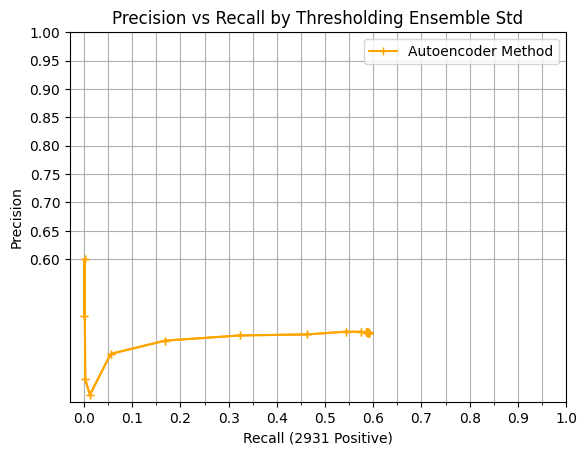

In [51]:
threshs = sp_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20) # Diff std. dev. thresholds (20 of them in this case)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs] # Portion of instances rejected @ each std threshold
accus = [np.mean((ext_preds==external_Y)[(threshs<=s)]) for s in std_threshs] # Acc @ each std thresh.
tps = [np.sum(((external_Y)*(ext_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ext_preds)*(ext_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.6, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Autoencoder Method'])

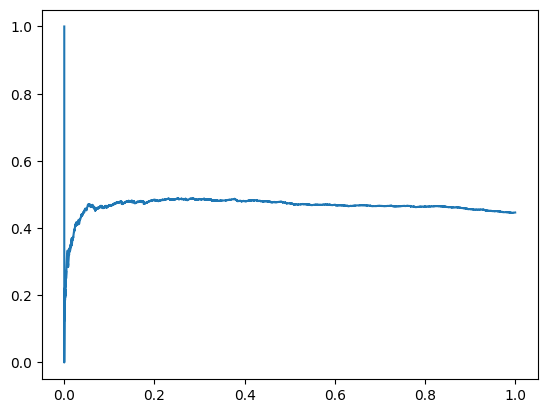

In [53]:
from sklearn.metrics import precision_recall_curve
p, r, thres = precision_recall_curve(external_Y, ext_probs)

plt.plot(r, p)